# Importing Modules

In [22]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 

from glob import glob
import librosa
import librosa.display 
import IPython.display as ipd

import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import os
from tqdm import tqdm

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import sounddevice as sd

# Data Exploration

In [26]:
chord_files = glob("./chords/AcousticOnly/*/*.wav")

In [27]:
ipd.Audio(chord_files[0])

In [28]:
y, sr = librosa.load(chord_files[0])
print(f"y: {y[:10]}")
print(f'shape y: {y.shape}')
print(f"sr: {sr}")

y: [1.1421539e-04 1.4294850e-04 8.0927217e-05 6.5227316e-05 1.4668878e-04
 1.6033459e-04 7.5453921e-05 7.0173650e-05 1.4214107e-04 1.2768534e-04]
shape y: (49674,)
sr: 22050


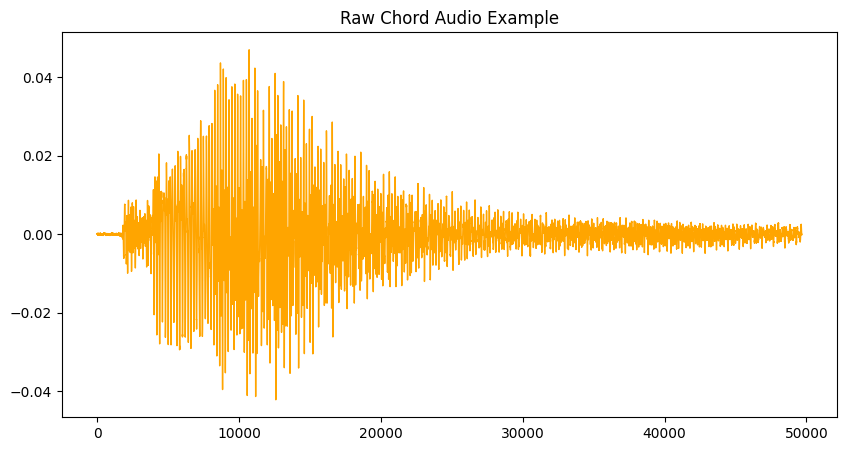

In [29]:
pd.Series(y).plot(figsize = (10,5), lw=1, title="Raw Chord Audio Example", color="orange")
plt.show()

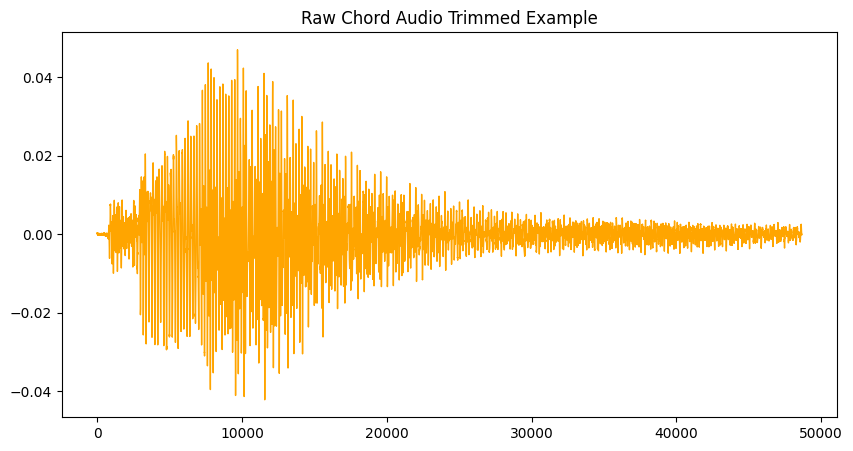

In [30]:
# trimming the audio to get only the necessay sounds (e.g removing silence)
y_trimmed, _ = librosa.effects.trim(y, top_db=30)

pd.Series(y_trimmed).plot(figsize = (10,5), lw=1, title="Raw Chord Audio Trimmed Example", color="orange")
plt.show()

##### 

# Spectogram 

In [31]:
D = librosa.stft(y)
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
S_db.shape

(1025, 98)

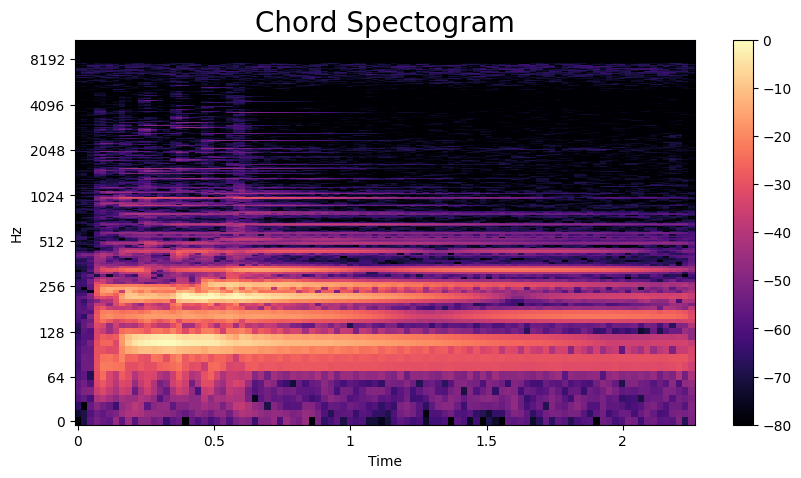

In [32]:
fig, ax = plt.subplots(figsize=(10,5))
img = librosa.display.specshow(S_db, x_axis='time', y_axis="log", ax=ax)
ax.set_title('Chord Spectogram', fontsize=20)
fig.colorbar(img, ax=ax) 
plt.show()

# Mel Spectogram

In [34]:
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=256)
S_db_mel = librosa.amplitude_to_db(S, ref=np.max)

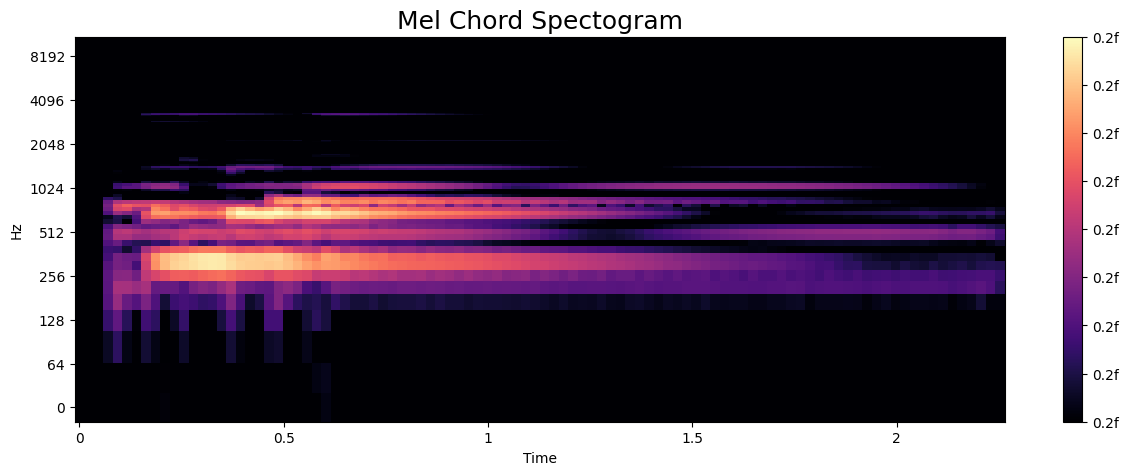

In [35]:
fig, ax = plt.subplots(figsize=(15,5))
img = librosa.display.specshow(S_db_mel, x_axis = "time", y_axis = "log", ax=ax)
ax.set_title('Mel Chord Spectogram', fontsize=18)
fig.colorbar(img, ax=ax, format=f'0.2f')
plt.show()


# Preprocessing Audio Files

In [36]:
# Initialize variables
mel_specs = []
labels = []

# iterating through all the audio files and making Mel-spectrograms
for file_path in tqdm(chord_files):
    # labelling based on the folder name (G, Em, etc.)
    label = os.path.basename(os.path.dirname(file_path)) 
    y, sr = librosa.load(file_path)
    y_trimmed, _ = librosa.effects.trim(y, top_db=30)
    
    # computing Mel-spectrogram
    mel_spec = librosa.feature.melspectrogram(y=y_trimmed, sr=sr, n_mels=128)
    mel_spec_db = librosa.amplitude_to_db(mel_spec, ref=np.max)
    
    # adding a channel dimension to make it 3D (height, width, channels)
    mel_spec_db = mel_spec_db[..., np.newaxis]
    
    # resizing to make sure  uniform dimensions
    mel_spec_db_resized = tf.image.resize(mel_spec_db, [128, 128]).numpy()
    
    mel_specs.append(mel_spec_db_resized)
    labels.append(label)

# converting the lists to arrays
mel_specs = np.array(mel_specs)
labels = np.array(labels)

# encoding labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# saving the label encoder classes
np.save('label_classes.npy', label_encoder.classes_)

100%|██████████████████████████████████████████████████████████████████████████████| 1152/1152 [00:28<00:00, 39.78it/s]


# Train Test Split

In [37]:
# splitting into train and test sets 
X_train, X_test, y_train, y_test = train_test_split(mel_specs, encoded_labels, test_size=0.2, random_state=42)

# adding a channel dimension for the cnn model 
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]

# normalizing the data
X_train = X_train / 255.0
X_test = X_test / 255.0

# Model Initialization and Training 

In [38]:
# CNN model 
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(128, 128, 1)), 
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(label_encoder.classes_), activation='softmax')
])


In [39]:
# compiling the model with the adam optimizer
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [40]:
# training the model
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test), batch_size=32)

Epoch 1/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 167ms/step - accuracy: 0.1116 - loss: 2.0978 - val_accuracy: 0.3333 - val_loss: 2.0758
Epoch 2/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 159ms/step - accuracy: 0.2020 - loss: 2.0270 - val_accuracy: 0.7143 - val_loss: 1.3232
Epoch 3/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 157ms/step - accuracy: 0.6683 - loss: 1.0059 - val_accuracy: 0.9091 - val_loss: 0.3497
Epoch 4/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 163ms/step - accuracy: 0.8833 - loss: 0.3531 - val_accuracy: 0.9264 - val_loss: 0.2206
Epoch 5/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 162ms/step - accuracy: 0.9540 - loss: 0.1630 - val_accuracy: 0.9567 - val_loss: 0.1665
Epoch 6/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 162ms/step - accuracy: 0.9632 - loss: 0.1171 - val_accuracy: 0.9567 - val_loss: 0.1358
Epoch 7/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 161ms/step - accuracy: 0.9767 - loss: 0.0726 - val_accuracy: 0.9654 - val_loss: 0.1071
Epoch 8/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 160ms/step - accuracy: 0.9811 - loss: 0.0642 - val_accuracy: 0.

# Model Evaluation 

In [42]:
# evalutation of the model 
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.3f}%")

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9693 - loss: 0.0801
Test Accuracy: 97.403%


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


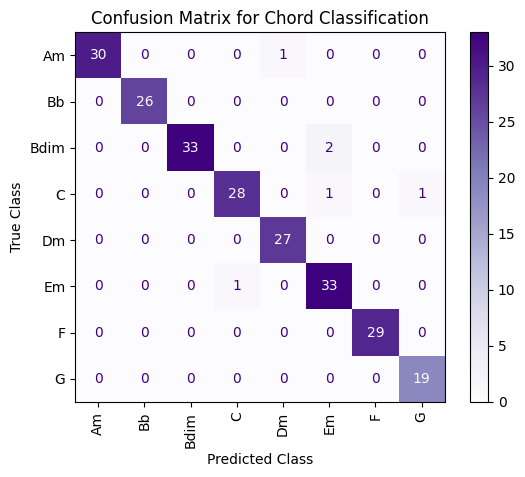

In [43]:
# get predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels

# make the confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Purples, xticks_rotation='vertical', values_format='d')

plt.title('Confusion Matrix for Chord Classification')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()


In [66]:
# save the model
model.save('chord_classification_acoustic_model.keras', include_optimizer=False)